# Tuning rasters for single neurons

By Charles Xu @ DJA Lab, Caltech

## Set up environment

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio

import sys
if '/Users/alveus/Documents/WorkingDirectory/Packages/Python' not in sys.path:
    sys.path.insert(0, '/Users/alveus/Documents/WorkingDirectory/Packages/Python')
import colormaps as cmaps # custom colormaps (see: https://gist.github.com/justiceamoh/0aca7df49c35fc0a38d2)

import statsmodels.api as sm

from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

# import ssm
# from ssm.util import find_permutation

In [2]:
# User inputs
data_path = r'/Users/alveus/Documents/WorkingDirectory/Data/DJA/Jineun/PythonData/EG1-4/priority_malemale' # Path to data on my Mac
data_name_fasted = r'EG1-4_fasted.mat'
data_name_fed = r'EG1-4_fed.mat'
exp_condition = 'both' # 'fasted', 'fed', or 'both'

# frame_rate = 10 # Frame rate of the data (in Hz)
# time_window = 5 # Time window for regressors (in seconds)
# time_step = 5 # Time step for the regressors (in frames)
# n_folds = 5 # Number of folds for cross-validation
# good_beta_threshold = 0.5 # Threshold for good betas as a proportion of the maximum beta

### Load data

In [3]:
# Load data
if exp_condition == 'fasted':
    data_fullfile = data_path + '/' + data_name_fasted
    mat = sio.loadmat(data_fullfile)
    input_raw = mat['behaviorFullMaFPS']
    output_raw = np.array(mat['neural_ref'])
    # output_raw = np.array(mat['neural_data_fed_0703'])
    labels_raw = mat['behaviorNames']
    labels = []
    for i in range(len(labels_raw)):
        labels.append(labels_raw[i][0][0])
elif exp_condition == 'fed':
    data_fullfile = data_path + '/' + data_name_fed
    mat = sio.loadmat(data_fullfile)
    input_raw = mat['behaviorFullMaFPS']
    output_raw = np.array(mat['neural_ref'])
    # output_raw = np.array(mat['neural_data_fed_0703'])
    labels_raw = mat['behaviorNames']
    labels = []
    for i in range(len(labels_raw)):
        labels.append(labels_raw[i][0][0])
elif exp_condition == 'both':
    data_fullfile_fasted = data_path + '/' + data_name_fasted
    data_fullfile_fed = data_path + '/' + data_name_fed
    mat_fasted = sio.loadmat(data_fullfile_fasted)
    mat_fed = sio.loadmat(data_fullfile_fed)
    input_raw_fasted = mat_fasted['behaviorFullMaFPS']
    input_raw_fed = mat_fed['behaviorFullMaFPS']
    output_raw_fasted = np.array(mat_fasted['neural_ref'])
    output_raw_fed = np.array(mat_fed['neural_ref'])
    labels_raw_fasted = mat_fasted['behaviorNames']
    labels_raw_fed = mat_fed['behaviorNames']
    labels_fasted = []
    for i in range(len(labels_raw_fasted)):
        labels_fasted.append(labels_raw_fasted[i][0][0])
    labels_fed = []
    for i in range(len(labels_raw_fed)):
        labels_fed.append(labels_raw_fed[i][0][0])
else:
    sys.exit('Wrong experiment condition! Specify either "fasted", "fed", or "both".')


In [4]:
print(labels_fasted) # Missing 'attack_attempt'
print(labels_fed) # Missing 'eating' and 'drinking'

['attack', 'chasing', 'danglingM', 'drinking', 'eating', 'food_approach', 'food_sniff', 'introduction', 'male_approach', 'mountM', 'self_grooming', 'sniffM', 'sniff_face']
['attack', 'attack_attempt', 'chase', 'danglingM', 'food_approach', 'food_sniff', 'introduction', 'male_approach', 'mountM', 'self_grooming', 'sniffM', 'sniff_face']


In [19]:
time_fasted

array([    0,     1,     2, ..., 14756, 14757, 14758])

## Process data

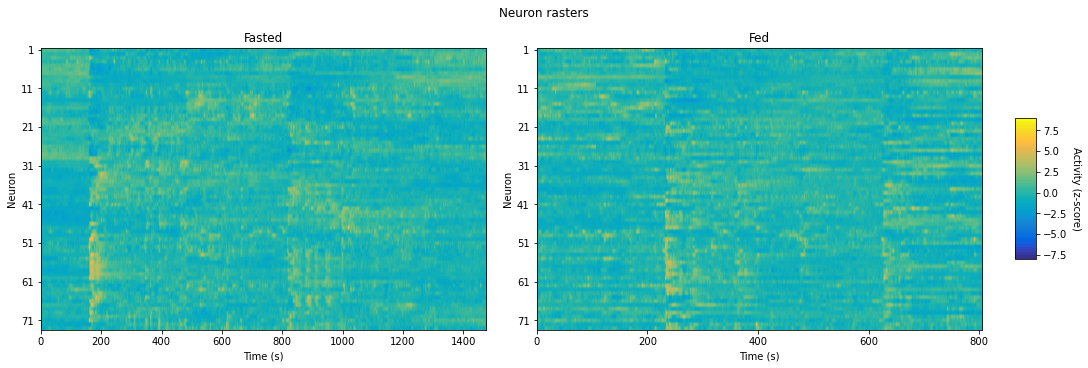

In [25]:
# Plot raw neuron rasters
if exp_condition == 'both':
    n_neurons = output_raw_fasted.shape[0]
    time_fasted = output_raw_fasted.shape[1]
    time_fed = output_raw_fed.shape[1]

    fig, axs = plt.subplots(ncols = 2, figsize=(15, 5), constrained_layout=True)

    # Determine the color scale based on the min and max of both datasets
    vmin = min(output_raw_fasted.min(), output_raw_fed.min())
    vmax = max(output_raw_fasted.max(), output_raw_fed.max())

    im0 = axs[0].imshow(output_raw_fasted, cmap=cmaps.parula, aspect='auto', vmin=vmin, vmax=vmax)
    axs[0].set_title('Fasted')
    axs[0].set_xticks(np.arange(time_fasted, step=2000))
    axs[0].set_xticklabels(np.arange(time_fasted, step=2000)//10)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_yticks(np.arange(n_neurons, step=10))
    axs[0].set_yticklabels(np.arange(n_neurons, step=10)+1)
    axs[0].set_ylabel('Neuron')

    im1 = axs[1].imshow(output_raw_fed, cmap=cmaps.parula, aspect='auto', vmin=vmin, vmax=vmax)
    axs[1].set_title('Fed')
    axs[1].set_xticks(np.arange(time_fed, step=2000))
    axs[1].set_xticklabels(np.arange(time_fed, step=2000)//10)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_yticks(np.arange(n_neurons, step=10))
    axs[1].set_yticklabels(np.arange(n_neurons, step=10)+1)
    axs[1].set_ylabel('Neuron')

    plt.suptitle('Neuron rasters')

    # Add a colarbar
    cbar = fig.colorbar(im0, ax=axs, shrink=0.5, aspect=10)
    cbar.set_label('Activity (z-score)', rotation=-90, va="bottom")

In [5]:
# Manually process labels for both conditions
if exp_condition == 'both':
    labels_fasted.insert(1, 'attack_attempt') # Insert 'attack_attempt' at index 1 of `labels_fasted`
    attack_attempt_fasted = np.zeros(input_raw_fasted.shape[1], dtype=int) # Create an array of zeros for `attack_attempt` in fasted condition
    input_raw_fasted = np.insert(input_raw_fasted, 1, attack_attempt_fasted, axis=0) # Insert zeros at index 1 of `input_raw_fasted`

    labels_fed.insert(0, 'eating') # Insert 'eating' at index 0 of `labels_fed`
    eating_fed = np.zeros(input_raw_fed.shape[1], dtype=int) # Create an array of zeros for `eating` in fed condition
    input_raw_fed = np.insert(input_raw_fed, 0, eating_fed, axis=0) # Insert zeros at index 0 of `input_raw_fed`

    labels_fed.insert(0, 'drinking') # Insert 'drinking' at index 0 of `labels_fed`
    drinking_fed = np.zeros(input_raw_fed.shape[1], dtype=int) # Create an array of zeros for `drinking` in fed condition
    input_raw_fed = np.insert(input_raw_fed, 0, drinking_fed, axis=0) # Insert zeros at index 0 of `input_raw_fed`

    labels_fed[labels_fed.index('chase')] = 'chasing' # Change 'chase' to 'chasing' in `labels_fed`

    # Reorder labels_fed and input_raw_fed according to labels_fasted
    sorted_indices = [labels_fed.index(l) for l in labels_fasted]
    labels_fed = [labels_fed[i] for i in sorted_indices]
    input_raw_fed = input_raw_fed[sorted_indices, :]

In [6]:
# If labels are the same, use `labels`
if labels_fasted == labels_fed:
    labels = labels_fasted
    print('Labels are the same: ' + str(labels_fasted == labels_fed))

print(labels)

Labels are the same: True
['attack', 'attack_attempt', 'chasing', 'danglingM', 'drinking', 'eating', 'food_approach', 'food_sniff', 'introduction', 'male_approach', 'mountM', 'self_grooming', 'sniffM', 'sniff_face']


In [7]:
# Include baseline as a label
if exp_condition == 'fasted':
    labels.insert(0, 'baseline')
    first_behavior_idx = np.nonzero(np.sum(input_raw, axis=0))[0][0] # Find the index of the first behavior
    baseline_fasted = np.zeros(input_raw.shape[1], dtype=int)
    baseline_fasted[first_behavior_idx-1200:first_behavior_idx] = 1 # Set the baseline to be 2 minutes before the first behavior
    input_raw = np.vstack((baseline_fasted, input_raw))
elif exp_condition == 'fed':
    labels.insert(0, 'baseline')
    first_behavior_idx = np.nonzero(np.sum(input_raw, axis=0))[0][0]
    baseline_fed = np.zeros(input_raw.shape[1], dtype=int)
    baseline_fed[first_behavior_idx-1200:first_behavior_idx] = 1
    input_raw = np.vstack((baseline_fed, input_raw))
else:
    labels.insert(0, 'baseline')
    # Find the index of the first behavior for each condition
    first_behavior_idx_fasted = np.nonzero(np.sum(input_raw_fasted, axis=0))[0][0]
    first_behavior_idx_fed = np.nonzero(np.sum(input_raw_fed, axis=0))[0][0]
    # Create an array of zeros for `baseline` in each condition
    baseline_fasted = np.zeros(input_raw_fasted.shape[1], dtype=int)
    baseline_fed = np.zeros(input_raw_fed.shape[1], dtype=int)
    # Set the baseline to be 2 minutes before the first behavior in each condition
    baseline_fasted[first_behavior_idx_fasted-1200:first_behavior_idx_fasted] = 1
    baseline_fed[first_behavior_idx_fed-1200:first_behavior_idx_fed] = 1
    # Insert baseline values in the first row of each condition
    input_raw_fasted = np.vstack((baseline_fasted, input_raw_fasted))
    input_raw_fed = np.vstack((baseline_fed, input_raw_fed))

In [8]:
# Reorder labels and input_raw according to labels
if exp_condition == 'both':
    labels_grouped = ['baseline', # Baseline
                    'danglingM', 'introduction', 'male_approach', # Novelty
                    'attack', 'attack_attempt', 'chasing', 'mountM', 'sniffM', 'sniff_face', # Consumatory
                    'food_approach', 'food_sniff', 'eating', 'drinking', # Food
                    'self_grooming'
                    ]
    group_indices = [1, 4, 10, 14]
    
    sorted_indices = [labels.index(l) for l in labels_grouped]
    labels = [labels[i] for i in sorted_indices]

    input_raw_fasted = input_raw_fasted[sorted_indices, :]
    input_raw_fed = input_raw_fed[sorted_indices, :]

In [9]:
n_labels = len(labels)
print(f'Number of labels: {n_labels}, they are: {labels}')
if exp_condition == 'both':
    print(f'The sizes of input_raw_fasted and input_raw_fed are: {input_raw_fasted.shape} and {input_raw_fed.shape}, respectively.')

Number of labels: 15, they are: ['baseline', 'danglingM', 'introduction', 'male_approach', 'attack', 'attack_attempt', 'chasing', 'mountM', 'sniffM', 'sniff_face', 'food_approach', 'food_sniff', 'eating', 'drinking', 'self_grooming']
The sizes of input_raw_fasted and input_raw_fed are: (15, 14759) and (15, 8043), respectively.


#### Compute mean activity for each neuron and each behavior

In [10]:
if exp_condition == 'both':
    mean_activity_fasted = np.zeros((n_labels, n_neurons))
    mean_activity_fed = np.zeros((n_labels, n_neurons))
    for l in range(n_labels):
        mean_activity_fasted[l,:] = np.nan_to_num(np.mean(output_raw_fasted[:,np.where(input_raw_fasted[l,:] == 1)[0]], axis=1))
        mean_activity_fed[l,:] = np.nan_to_num(np.mean(output_raw_fed[:,np.where(input_raw_fed[l,:] == 1)[0]], axis=1))
else:
    n_labels = len(labels)
    n_neurons = output_raw.shape[0]
    mean_activity = np.zeros((n_labels, n_neurons))
    for l in range(n_labels):
        mean_activity[l,:] = np.mean(output_raw[:,np.where(input_raw[l,:] == 1)[0]], axis=1)

/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


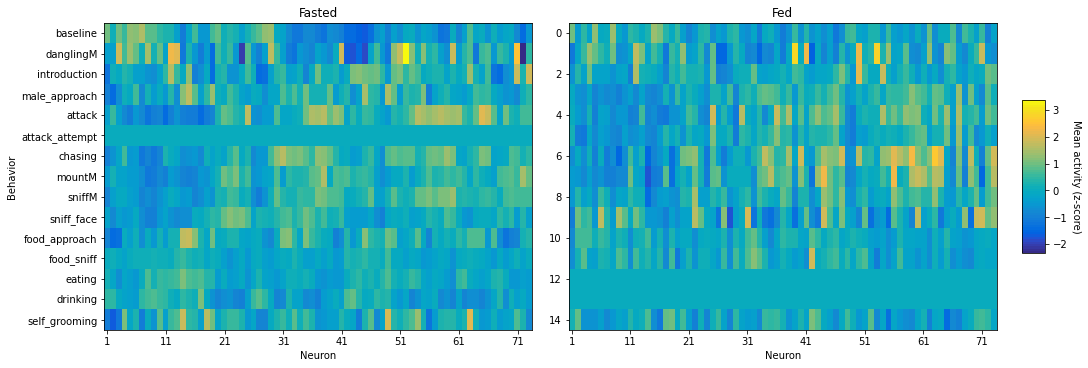

In [11]:
# Plot mean activity
if exp_condition == 'both':
    fig, axs = plt.subplots(ncols = 2, figsize=(15, 5), constrained_layout=True)

    # Determine the color scale based on the min and max of both datasets
    vmin = min(mean_activity_fasted.min(), mean_activity_fed.min())
    vmax = max(mean_activity_fasted.max(), mean_activity_fed.max())

    im0 = axs[0].imshow(mean_activity_fasted, cmap=cmaps.parula, aspect='auto', vmin=vmin, vmax=vmax)
    axs[0].set_title('Fasted')
    axs[0].set_xticks(np.arange(n_neurons, step=10))
    axs[0].set_xticklabels(np.arange(n_neurons, step=10)+1)
    axs[0].set_xlabel('Neuron')
    axs[0].set_yticks(np.arange(n_labels))
    axs[0].set_yticklabels(labels)
    axs[0].set_ylabel('Behavior')

    im1 = axs[1].imshow(mean_activity_fed, cmap=cmaps.parula, aspect='auto', vmin=vmin, vmax=vmax)
    axs[1].set_title('Fed')
    axs[1].set_xticks(np.arange(n_neurons, step=10))
    axs[1].set_xticklabels(np.arange(n_neurons, step=10)+1)
    axs[1].set_xlabel('Neuron')

    # Add a colarbar
    cbar = fig.colorbar(im0, ax=axs, shrink=0.5, aspect=10)
    cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")
else:
    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
    im = ax.imshow(mean_activity, cmap=cmaps.parula, aspect='auto')
    ax.set_xticks(np.arange(n_neurons, step=10))
    ax.set_xticklabels(np.arange(n_neurons, step=10)+1)
    ax.set_xlabel('Neuron')
    ax.set_yticks(np.arange(n_labels))
    ax.set_yticklabels(labels)
    ax.set_ylabel('Behavior')
    cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")

plt.suptitle('Mean activity')

## Cluster neurons

In [12]:
# Define function to perform k-means with silhouette analysis
def plot_kmeans_silhouette(range_n_clusters, data):
    """
    range_n_clusters: range of number of clusters to evaluate
    data: data (n_samples, n_features) to perform k-means with silhouette analysis on
    """
    n_samples = data.shape[0]
    num_clusters = len(range_n_clusters)
    silhouette_scores = []
    fig, axs = plt.subplots(nrows=num_clusters, ncols=2, figsize=(10, 4*num_clusters), constrained_layout=True)
    for i in range(num_clusters):
        n_clusters = range_n_clusters[i]
        axs[i, 0].set_xlim([-0.1, 1])
        axs[i, 0].set_ylim([0, n_samples + (n_clusters + 1) * 10])

        # Fit the KMeans model and calculate silhouette scores
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
        cluster_labels = kmeans.labels_
        silhouette_score_value = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_score_value)
        silhouette_scores.append(silhouette_score_value)
        silhouetee_samples = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for n in range(n_clusters):
            nth_cluster_silhouette_values = silhouetee_samples[cluster_labels == n] # Aggregate the silhouette scores for samples belonging to cluster n
            nth_cluster_silhouette_values.sort() # Sort the silhouette scores

            nth_cluster_size = nth_cluster_silhouette_values.shape[0] # Get the size of cluster n
            y_upper = y_lower + nth_cluster_size # Set the position of the silhouette plot for cluster n
            color = cm.nipy_spectral(float(n) / n_clusters)
            axs[i, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, nth_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            axs[i, 0].text(-0.05, y_lower + 0.5 * nth_cluster_size, str(n)) # Label the silhouette plots with their cluster numbers at the middle

            y_lower = y_upper + 10

        axs[i, 0].set_title("Silhouette plot for the various clusters (n_clusters = %d)" % n_clusters)
        axs[i, 0].set_xlabel("Silhouette coefficient values")
        axs[i, 0].set_ylabel("Cluster label")

        axs[i, 0].axvline(x=silhouette_score_value, color="red", linestyle="--")
        axs[i, 0].set_yticks([])  # Clear the yaxis labels / ticks
        axs[i, 0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot the cluster
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        if data.shape[1] == 2:
            axs[i, 1].scatter(data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = kmeans.cluster_centers_
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("Visualization of the clustered data (n_clusters = %d)" % n_clusters)
            axs[i, 1].set_xlabel("1st feature in feature space")
            axs[i, 1].set_ylabel("2nd feature in feature space")

        else:
            pca = PCA(n_components=2).fit(data)
            data_pca = pca.transform(data)
            axs[i, 1].scatter(data_pca[:, 0], data_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = pca.transform(kmeans.cluster_centers_)
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("The visualization of the clustered data.")
            axs[i, 1].set_xlabel("PC1 in PCA mapping of feature space")
            axs[i, 1].set_ylabel("PC2 in PCA mapping of feature space")

        plt.suptitle(
            "k-means clustering with Sillhouette analysis",
            fontsize=14,
            fontweight="bold",
        )

    print("The number of clusters that maximizes silhouette score is: ", range_n_clusters[np.argmax(silhouette_scores)])
    return fig, axs, range_n_clusters[np.argmax(silhouette_scores)]

In [13]:
# Perform k-means with silhouette analysis
range_n_clusters = np.arange(2, n_labels+1) # Generate range of number of clusters to evaluate

if exp_condition == 'both':
    fig, axs, n_clusters_fasted = plot_kmeans_silhouette(range_n_clusters, mean_activity_fasted.T)
    plt.close(fig)
    fig, axs, n_clusters_fed = plot_kmeans_silhouette(range_n_clusters, mean_activity_fed.T)
    plt.close(fig)
else:
    fig, axs, n_clusters = plot_kmeans_silhouette(range_n_clusters, mean_activity.T)
    plt.close(fig)

/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 the average silhouette_score is : 0.2393573786528012


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

For n_clusters = 3 the average silhouette_score is : 0.18701662144617603
For n_clusters = 4 the average silhouette_score is : 0.19142333902252234
For n_clusters = 5 the average silhouette_score is : 0.1800100799706099
For n_clusters = 6 the average silhouette_score is : 0.153319248874907
For n_clusters = 7 the average silhouette_score is : 0.16240454618131248
For n_clusters = 8 the average silhouette_score is : 0.1557148493765607


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9 the average silhouette_score is : 0.14388427624365333
For n_clusters = 10 the average silhouette_score is : 0.13828555380952848
For n_clusters = 11 the average silhouette_score is : 0.13699743195705624


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 12 the average silhouette_score is : 0.14305925211000797
For n_clusters = 13 the average silhouette_score is : 0.14730470838063167


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 14 the average silhouette_score is : 0.14157626650222263
For n_clusters = 15 the average silhouette_score is : 0.14106868665598318
The number of clusters that maximizes silhouette score is:  2


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

For n_clusters = 2 the average silhouette_score is : 0.2621801934657493
For n_clusters = 3 the average silhouette_score is : 0.21824573090133123
For n_clusters = 4 the average silhouette_score is : 0.2063810510973834
For n_clusters = 5 the average silhouette_score is : 0.18652351580427023
For n_clusters = 6 the average silhouette_score is : 0.17729710162476964


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

For n_clusters = 7 the average silhouette_score is : 0.17799812678597504
For n_clusters = 8 the average silhouette_score is : 0.1739370069194379
For n_clusters = 9 the average silhouette_score is : 0.16959598612330082
For n_clusters = 10 the average silhouette_score is : 0.19080275358229076
For n_clusters = 11 the average silhouette_score is : 0.1790775859333972


/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

For n_clusters = 12 the average silhouette_score is : 0.15653699160863987
For n_clusters = 13 the average silhouette_score is : 0.1783978642930011
For n_clusters = 14 the average silhouette_score is : 0.16116218831825993
For n_clusters = 15 the average silhouette_score is : 0.16387607190311373
The number of clusters that maximizes silhouette score is:  2


## Generate raster plots

In [14]:
# Define function to cluster neurons
def fit_kmeans(n_clusters, data, neuron_ids=None):
    """
    n_clusters: number of clusters to group neurons into
    data: data (n_samples, n_features) to perform k-means clustering on
    neuron_ids: subset of neurons (n_neurons, ) to cluster
    """
    # Fit k-means clustering with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    cluster_labels = kmeans.labels_

    # Group neurons by cluster
    data_reordered = np.zeros_like(data)
    neuron_ids_reordered = np.zeros_like(cluster_labels)
    n_ith_cluster_lower = 0
    n_ith_cluster_upper = 0
    for i in range(n_clusters):
        n_ith_cluster_upper = n_ith_cluster_lower + sum(cluster_labels == i)
        data_reordered[n_ith_cluster_lower:n_ith_cluster_upper, :] = data[cluster_labels == i, :]
        if neuron_ids is None:
            neuron_ids_reordered[n_ith_cluster_lower:n_ith_cluster_upper] = np.where(cluster_labels == i)[0] + 1
        else:
            neuron_ids_reordered[n_ith_cluster_lower:n_ith_cluster_upper] = neuron_ids[np.where(cluster_labels == i)] + 1
        n_ith_cluster_lower = n_ith_cluster_upper

    return cluster_labels, data_reordered, neuron_ids_reordered

/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


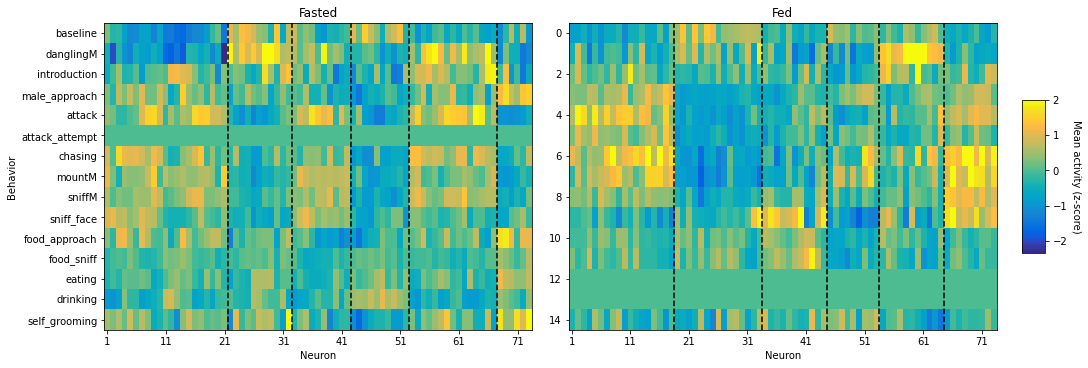

In [17]:
# Plot tuning raster with n_labels clusters
if exp_condition == 'both':
    # Fit k-means clustering with n_labels
    n_clusters_fasted = 6
    n_clusters_fed = 6
    cluster_labels_fasted, data_reordered_fasted, neuron_ids_reordered_fasted = fit_kmeans(n_clusters_fasted, mean_activity_fasted.T)
    cluster_labels_fed, data_reordered_fed, neuron_ids_reordered_fed = fit_kmeans(n_clusters_fed, mean_activity_fed.T)

    # Plot tuning raster
    fig, axs = plt.subplots(ncols = 2, figsize=(15, 5), constrained_layout=True)

    # Determine the color scale based on the min and max of both datasets
    vmin = min(mean_activity_fasted.min(), mean_activity_fed.min())
    vmax = max(mean_activity_fasted.max(), mean_activity_fed.max())

    # Plot the first raster
    im0 = axs[0].imshow(data_reordered_fasted.T, cmap=cmaps.parula, aspect='auto', vmin=vmin, vmax=2)
    axs[0].set_title('Fasted')
    axs[0].set_xticks(np.arange(n_neurons, step=10))
    axs[0].set_xticklabels(np.arange(n_neurons, step=10)+1)
    axs[0].set_xlabel('Neuron')
    axs[0].set_yticks(np.arange(n_labels))
    axs[0].set_yticklabels(labels)
    axs[0].set_ylabel('Behavior')

    # Separate clusters
    for i in range(1, n_clusters_fasted):
        axs[0].axvline(x=np.sum(cluster_labels_fasted < i) - 1/2, color='black', linestyle='--')

    # Plot the second raster
    im1 = axs[1].imshow(data_reordered_fed.T, cmap=cmaps.parula, aspect='auto', vmin=vmin, vmax=2)
    axs[1].set_title('Fed')
    axs[1].set_xticks(np.arange(n_neurons, step=10))
    axs[1].set_xticklabels(np.arange(n_neurons, step=10)+1)
    axs[1].set_xlabel('Neuron')

    # Separate clusters
    for i in range(1, n_clusters_fed):
        axs[1].axvline(x=np.sum(cluster_labels_fed < i) - 1/2, color='black', linestyle='--')

    # Add a colarbar
    cbar = fig.colorbar(im0, ax=axs, shrink=0.5, aspect=10)
    cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")
else:
    # Fit k-means clustering with n_labels
    n_clusters = n_labels
    cluster_labels, data_reordered, neuron_ids_reordered = fit_kmeans(n_clusters, mean_activity.T)

    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
    im = ax.imshow(data_reordered.T, cmap=cmaps.parula, aspect='auto')
    ax.set_xticks(np.arange(n_neurons, step=10))
    ax.set_xticklabels(np.arange(n_neurons, step=10)+1)
    ax.set_xlabel('Neuron')
    ax.set_yticks(np.arange(n_labels))
    ax.set_yticklabels(labels)
    ax.set_ylabel('Behavior')

    # Separate clusters
    for i in range(1, n_clusters):
        ax.axvline(x=np.sum(cluster_labels < i) - 1/2, color='black', linestyle='--')

    # Add a colarbar
    cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")

In [ ]:
# Define function to plot neural activity traces with input labels
def plot_trace(y, neuron_id):
    """
    y: normalized neural data
    neuron_id: neuron number
    """
    neuron_idx = neuron_id - 1
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(y[:,neuron_idx], color='k', label='neuron %d' % neuron_id)
    ax.set_xticks(np.arange(0, y.shape[0], 2000))
    ax.set_xticklabels(np.arange(0, y.shape[0], 2000) // 10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0, y.shape[0]])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neural activity')
    ax.set_title(f'Neural activity (z-score) for neuron {neuron_id}')

    return fig, ax

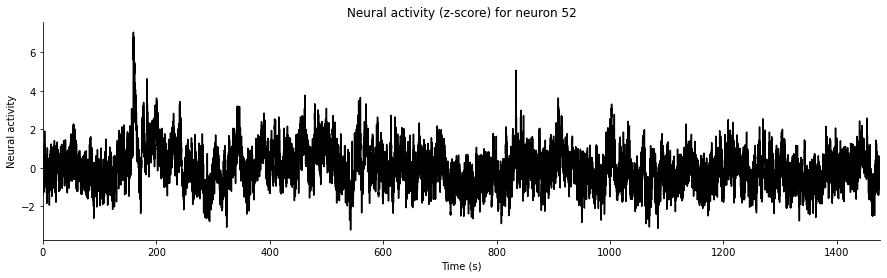

In [ ]:
fig, ax = plot_trace(output_raw.T, 52)